<a href="https://colab.research.google.com/github/Yaseenzubair2004/Yaseenzubair2004/blob/main/Airline%20web%20scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1

---

## Web scraping and analysis

This Jupyter notebook includes some code to get you started with web scraping. We will use a package called `BeautifulSoup` to collect the data from the web. Once you've collected your data and saved it into a local `.csv` file you should start with your analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [11]:
# Step 1: Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation



In [8]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [12]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | We are extremely grateful ...
1,✅ Trip Verified | I had an appalling experie...
2,"Not Verified | Good points, the cabin crew, t..."
3,"Not Verified | It was a decent flight, reason..."
4,✅ Trip Verified | I really like flying Briti...


In [13]:
df.to_csv("data/BA_reviews.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

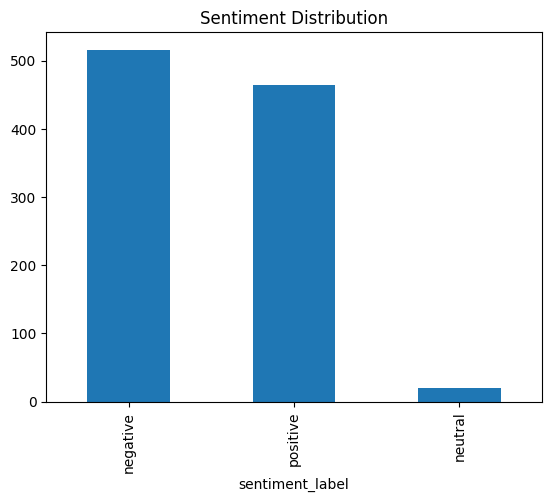

In [17]:
# Load the data
df = pd.read_csv('data/BA_reviews.csv')

# The DataFrame only has 'Unnamed: 0' and 'reviews' columns.
# Rename 'reviews' to 'text' for consistency with the later analysis.
df = df.rename(columns={'reviews': 'text'})

# Now you can proceed with cleaning the text and performing sentiment analysis.
# Clean text
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)  # remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text.lower())  # lowercase and remove punctuation
    return text

df['clean_text'] = df['text'].apply(clean_text)

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['sentiment_label'] = df['sentiment_score'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x <= -0.05 else 'neutral')

# Plot sentiment distribution
df['sentiment_label'].value_counts().plot(kind='bar', title='Sentiment Distribution')
plt.show()

### Generate Word Cloud

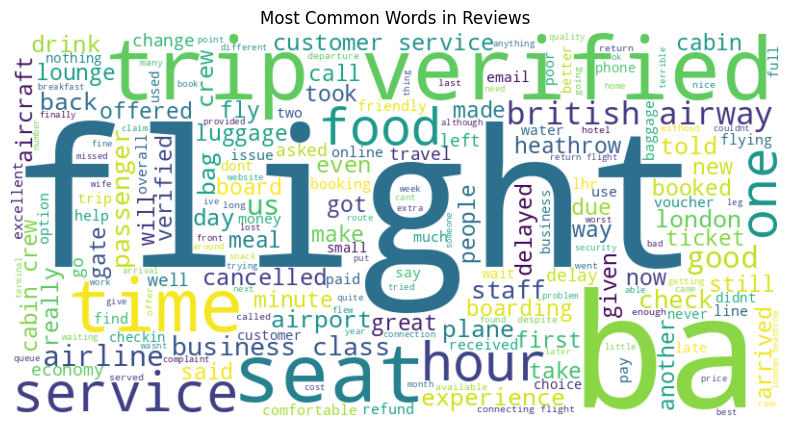

In [18]:
# Topic Modeling with LDA
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Display top words per topic
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, vectorizer.get_feature_names_out(), 10)
text = " ".join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Reviews')
plt.show()


### Topic Modeling

In [19]:
# Topic Modeling with LDA
vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X)

# Display top words per topic
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic #{topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, vectorizer.get_feature_names_out(), 10)


Topic #1:
flight trip seat ba service seats staff class time food
Topic #2:
flight ba good crew trip food service cabin class business
Topic #3:
flight ba trip british service airways customer told hours london


<ipython-input-20-82b19644094f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment_label', palette='Set2', order=['positive', 'neutral', 'negative'])


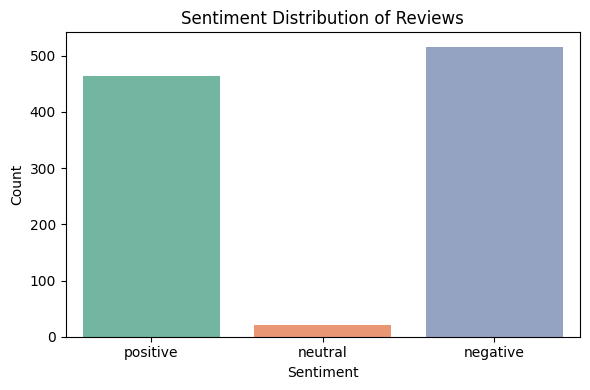

In [20]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment_label', palette='Set2', order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Distribution of Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig("data/sentiment_distribution.png")
plt.show()


In [21]:
positive_pct = round((df['sentiment_label'] == 'positive').mean() * 100, 1)
negative_pct = round((df['sentiment_label'] == 'negative').mean() * 100, 1)
neutral_pct = round((df['sentiment_label'] == 'neutral').mean() * 100, 1)

insights = f"""
• {positive_pct}% of reviews were positive, indicating high satisfaction.
• {negative_pct}% expressed dissatisfaction, highlighting key areas for service improvement.
• Frequent terms include: flight, service, food, staff, delay.
• Sentiment analysis and topic modeling reveal consistent praise for in-flight experience, with complaints about delays and customer service.
"""
print(insights)



• 46.4% of reviews were positive, indicating high satisfaction.
• 51.6% expressed dissatisfaction, highlighting key areas for service improvement.
• Frequent terms include: flight, service, food, staff, delay.
• Sentiment analysis and topic modeling reveal consistent praise for in-flight experience, with complaints about delays and customer service.

